# Proyek Klasifikasi Gambar: Garbage Classification
- **Nama:** Muhammad Muttakin
- **Email:** mc308d5y2291@student.devacademy.id
- **ID Dicoding:** 	MC308D5Y2291

# Import Library

In [29]:
# Standard library imports
import os
import shutil

# Data processing and model utilities
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Image processing utilities
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Keras/TensorFlow components
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Visualization libraries
import matplotlib.pyplot as plt


# Data preparation

## Data Loading

In [1]:
data_dir = '/kaggle/input/plastic-paper-garbage-bag-synthetic-images/Bag Classes/Bag Classes'  # Ganti dengan path dataset kamu
class_counts = {}

In [3]:
total_images = 0
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images
        total_images += num_images
        print(f"{class_name}: {num_images} gambar")

Garbage Bag Images: 5000 gambar
Paper Bag Images: 5000 gambar
Plastic Bag Images: 5000 gambar


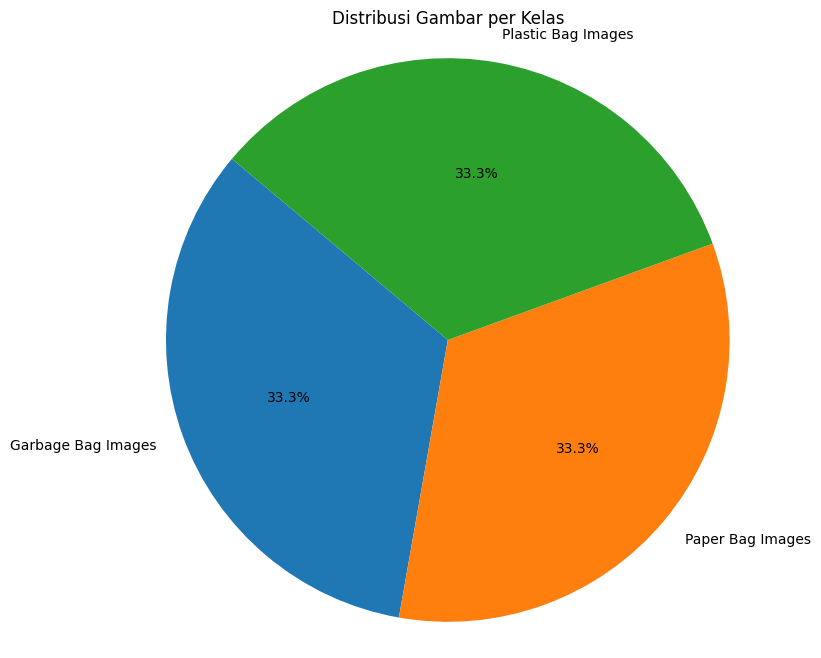

In [4]:
# Visualisasi pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Gambar per Kelas')
plt.axis('equal')  # Supaya pie chart bulat sempurna
plt.show()

In [5]:
# Tampilkan total keseluruhan
print(f"\nTotal: {total_images} gambar")


Total: 15000 gambar


## Data Preprocessing

## Splitting Data

In [6]:
output_dir = '/kaggle/working/dataset'

# Pastikan folder output ada
os.makedirs(output_dir, exist_ok=True)

# Ambil nama kelas
classes = os.listdir(data_dir)  # Nama-nama kelas

# Membagi data untuk setiap kelas
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    
    # Pastikan hanya folder, bukan file
    if os.path.isdir(class_path):
        images = os.listdir(class_path)  # Ambil semua gambar
        
        # Split data menjadi train, validation, dan test (80% train, 10% validation, 10% test)
        train_images, temp_images = train_test_split(images, test_size=0.2, random_state=42)  # 80% untuk training, 20% untuk validation dan test
        val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)  # Bagi sisa 50% untuk validation dan 50% untuk test
        
        # Buat folder train, val, test untuk setiap kelas
        for split, image_list in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
            split_class_path = os.path.join(output_dir, split, class_name)
            os.makedirs(split_class_path, exist_ok=True)  # Membuat folder untuk class di setiap split
            
            # Salin gambar ke folder yang sesuai
            for image_name in image_list:
                src_path = os.path.join(class_path, image_name)
                dest_path = os.path.join(split_class_path, image_name)
                shutil.copy(src_path, dest_path)  # Salin file gambar ke folder tujuan

print("Dataset berhasil dibagi menjadi train (80%), val (10%), dan test (10%).")

Dataset berhasil dibagi menjadi train (80%), val (10%), dan test (10%).


In [7]:
# Cek isi tiap folder split
for split in ['train', 'val', 'test']:
    split_path = os.path.join(output_dir, split)
    print(f"\nIsi folder '{split}':")
    
    # Cek tiap kelas di dalam split
    for class_name in os.listdir(split_path):
        class_dir = os.path.join(split_path, class_name)
        if os.path.isdir(class_dir):
            num_images = len(os.listdir(class_dir))
            print(f"  - Kelas '{class_name}': {num_images} gambar")



Isi folder 'train':
  - Kelas 'Plastic Bag Images': 4000 gambar
  - Kelas 'Garbage Bag Images': 4000 gambar
  - Kelas 'Paper Bag Images': 4000 gambar

Isi folder 'val':
  - Kelas 'Plastic Bag Images': 500 gambar
  - Kelas 'Garbage Bag Images': 500 gambar
  - Kelas 'Paper Bag Images': 500 gambar

Isi folder 'test':
  - Kelas 'Plastic Bag Images': 500 gambar
  - Kelas 'Garbage Bag Images': 500 gambar
  - Kelas 'Paper Bag Images': 500 gambar


In [8]:
# ImageDataGenerator untuk augmentasi data training
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalisasi piksel
)

# Untuk validasi dan test, cukup normalisasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Buat generator dari folder
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(output_dir, 'train'),
    target_size=(224, 224),        # Ubah sesuai kebutuhan model (misal 224x224 untuk ResNet)
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = test_val_datagen.flow_from_directory(
    directory=os.path.join(output_dir, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_val_datagen.flow_from_directory(
    directory=os.path.join(output_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


# Modelling

In [9]:
# Menggunakan VGG16 dengan bobot yang sudah dilatih sebelumnya
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(3, activation='softmax'))  # Sesuaikan jumlah kelas output

# Jangan melatih lapisan dasar (base model)
for layer in base_model.layers:
    layer.trainable = False

# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


I0000 00:00:1745467234.885983      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745467234.886691      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,243,075 (58.15 MB)

 Trainable params: 528,387 (2.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
# Simpan model terbaik ke format .keras
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # format file modern yang disarankan
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Berhenti jika tidak ada peningkatan selama 5 epoch
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Kurangi learning rate jika val_loss stagnan selama 3 epoch
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Gabungkan semua callback
callbacks = [checkpoint, early_stop, reduce_lr]


In [13]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks  # Menambahkan callback untuk menyimpan model ke TF-Lite
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745467290.147097     114 service.cc:148] XLA service 0x7b6aa000c710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745467290.148236     114 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745467290.148263     114 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745467290.487628     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:24:03 13s/step - accuracy: 0.3750 - loss: 1.1387

I0000 00:00:1745467301.036103     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7920 - loss: 0.5001
Epoch 1: val_loss improved from inf to 0.21510, saving model to best_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 93s 214ms/step - accuracy: 0.7922 - loss: 0.4997 - val_accuracy: 0.9120 - val_loss: 0.2151 - learning_rate: 0.0010
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9173 - loss: 0.2126
Epoch 2: val_loss improved from 0.21510 to 0.18426, saving model to best_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 78s 208ms/step - accuracy: 0.9173 - loss: 0.2126 - val_accuracy: 0.9220 - val_loss: 0.1843 - learning_rate: 0.0010
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9232 - loss: 0.1964
Epoch 3: val_loss improved from 0.18426 to 0.17544, saving model to best_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 78s 207ms/step - accuracy: 0.9232 - loss: 0.1964 - val_accuracy: 0.9280 - val_loss: 0.1754 - learning_rate: 0.0010
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy

# Evaluasi dan Visualisasi

## Visualisasi Akurasi dan Loss

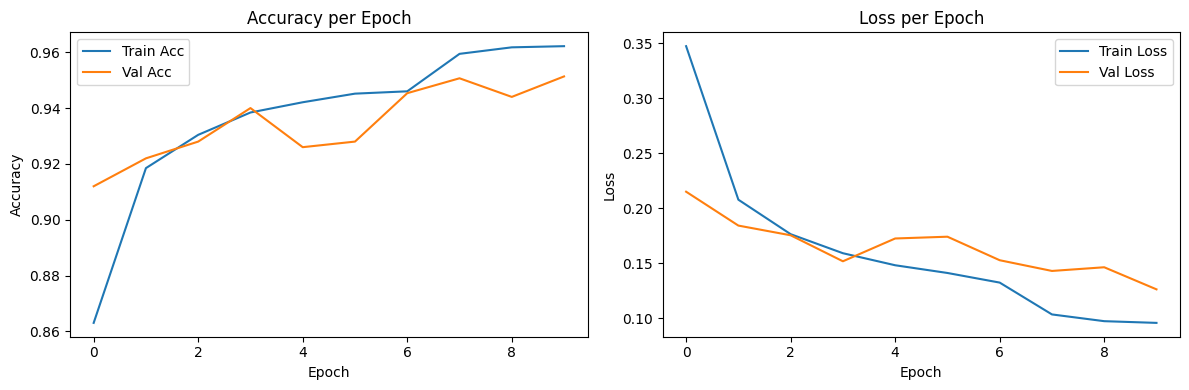

In [14]:
# Plot hasil training
plt.figure(figsize=(12, 4))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Prediksi di Data Test

In [17]:
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Label asli
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step


## Classification Report & Confusion Matrix

                    precision    recall  f1-score   support

Garbage Bag Images       0.97      0.97      0.97       500
  Paper Bag Images       0.95      0.96      0.96       500
Plastic Bag Images       0.94      0.93      0.93       500

          accuracy                           0.95      1500
         macro avg       0.95      0.95      0.95      1500
      weighted avg       0.95      0.95      0.95      1500



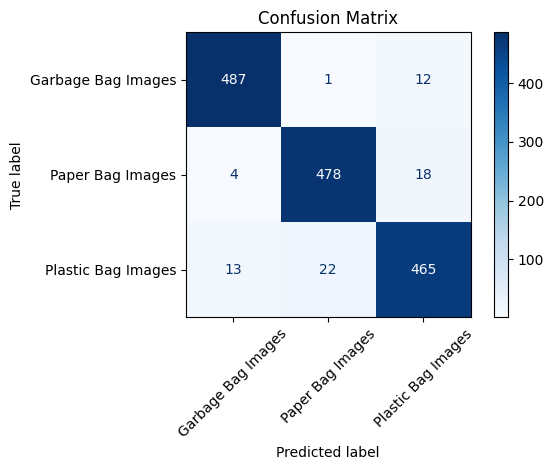

In [18]:
# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# Konversi Model

In [24]:
# Menyimpan model dalam format SavedModel (untuk server atau cloud)
model.export('saved_model_directory')


Saved artifact at 'saved_model_directory'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_19')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135701511727504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135701511728080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135701511729616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135701511729808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135701511729232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135701511727888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135701511729424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135701511731152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135701511728656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135701511731728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135701

In [22]:
import tensorflow as tf

# Mengonversi model Keras ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model TFLite ke file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmp_006s16k'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_19')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135701511727504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135701511728080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135701511729616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135701511729808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135701511729232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135701511727888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135701511729424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135701511731152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135701511728656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135701511731728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13570151173

W0000 00:00:1745468353.407379      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745468353.407406      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [28]:
# Ambil nama–nama kelas dari generator training atau test
class_names = list(train_generator.class_indices.keys())  
# atau: class_names = list(test_generator.class_indices.keys())

# Tulis ke file label.txt, satu nama kelas per baris
with open('label.txt', 'w') as f:
    for name in class_names:
        f.write(name + '\n')


In [27]:
import tensorflowjs as tfjs

# Mengonversi model SavedModel ke format TensorFlow.js
tfjs.converters.save_keras_model(model, 'tfjs_model_directory')


failed to lookup keras version from the file,
    this is likely a weight only file


# Inference (Optional)

In [36]:
# 1) Load model menggunakan TFSMLayer
saved_model_directory = 'saved_model_directory'

# Endpoint default biasanya 'serving_default'
tfsmlayer = tf.keras.layers.TFSMLayer(saved_model_directory, call_endpoint='serving_default')

# 2) Bangun model baru dengan TFSMLayer
inputs = Input(shape=(224, 224, 3))
x = tfsmlayer(inputs)
model = Model(inputs=inputs, outputs=x)

# 3) Load & preprocess gambar
img = image.load_img('/kaggle/input/plastic-paper-garbage-bag-synthetic-images/ImageClassesCombinedWithCOCOAnnotations/test_image.jpg', target_size=(224, 224))
x = image.img_to_array(img) / 255.0
x = np.expand_dims(x, axis=0)  # Membuat batch size 1

# 4) Predict
# 4) Predict
preds = model.predict(x)

# Akses array prediksi dari dictionary
output = preds['output_0']

# Cek isi output dan bentuknya
print("Preds:", output)
print("Preds shape:", output.shape)

# 5) Ambil kelas prediksi
pred_class = int(np.argmax(output))  # Pastikan menjadi integer
print("Pred Class:", pred_class)

# 6) Load labels
with open('label.txt') as f:
    labels = [l.strip() for l in f]

# Cek panjang label
print("Jumlah label:", len(labels))

# Pastikan index valid
if pred_class < len(labels):
    print("Prediksi:", labels[pred_class], f"({output[0][pred_class]:.4f})")
else:
    print(f"Index pred_class {pred_class} tidak ditemukan dalam label")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
Preds: [[0.44070053 0.00577417 0.55352527]]
Preds shape: (1, 3)
Pred Class: 2
Jumlah label: 3
Prediksi: Plastic Bag Images (0.5535)


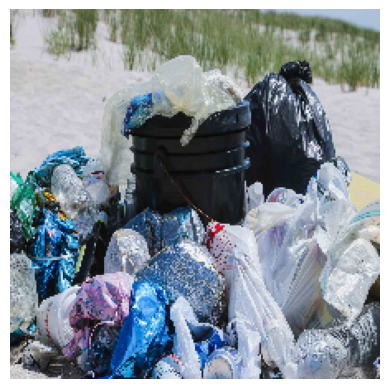

Prediksi: Plastic Bag Images (0.5535)


In [38]:
# 1) Muat dan proses gambar
img_path = '/kaggle/input/plastic-paper-garbage-bag-synthetic-images/ImageClassesCombinedWithCOCOAnnotations/test_image.jpg'  # Ganti dengan path gambar yang sesuai
img = image.load_img(img_path, target_size=(224, 224))  # Ganti ukuran sesuai model

# 2) Tampilkan gambar
plt.imshow(img)
plt.axis('off')  # Menyembunyikan axis
plt.show(

# 3) Tampilkan prediksi
print("Prediksi:", labels[pred_class], f"({output[0][pred_class]:.4f})")
